In [1]:
import findspark
findspark.init()
from pyspark import SparkContext
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('ml-bank').getOrCreate()
df = spark.read.csv('data/bank.csv', header=True, inferSchema=True)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [2]:
import pandas as pd
pd.DataFrame(df.take(5), columns=df.columns).T

,0,1,2,3,4
age,59,56,41,55,54
job,admin.,admin.,technician,services,admin.
marital,married,married,married,married,married
education,secondary,secondary,secondary,secondary,tertiary
default,no,no,no,no,no
balance,2343,45,1270,2476,184
housing,yes,no,yes,yes,no
loan,no,no,no,no,no
contact,unknown,unknown,unknown,unknown,unknown
day,5,5,5,5,5


In [5]:
num_features = [t[0] for t in df.dtypes if t[1]=='int']
df.select(num_features).describe().toPandas().T

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,11162,41.231947679627304,11.913369192215518,18,95
balance,11162,1528.5385235620856,3225.413325946149,-6847,81204
day,11162,15.658036194230425,8.420739541006462,1,31
duration,11162,371.99381831213043,347.12838571630687,2,3881
campaign,11162,2.508421429851281,2.7220771816614824,1,63
pdays,11162,51.33040673714388,108.75828197197717,-1,854
previous,11162,0.8325568894463358,2.292007218670508,0,58


C:\Users\amand\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  This is separate from the ipykernel package so we can avoid doing imports until


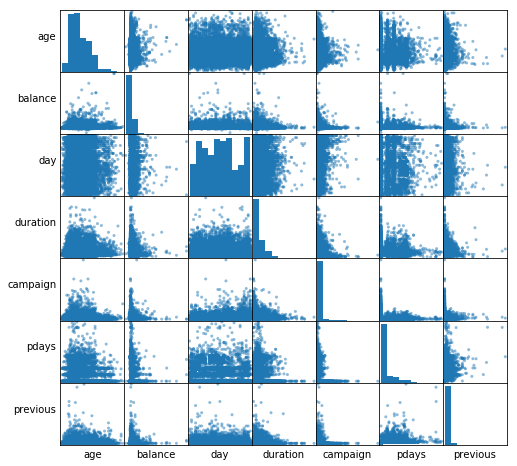

In [9]:
num_data = df.select(num_features).toPandas()

axs = pd.scatter_matrix(num_data, figsize=(8,8))

n = len(num_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1,i]
    h.set_xticks(())
    

In [10]:
df = df.select('age', 'job', 'marital', 'education', 'default', 'balance',
              'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays',
              'previous', 'poutcome', 'deposit')
cols = df.columns
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [11]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler

cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
           'poutcome']
stages = []

for cat_col in cat_cols:
    stringIndexer = StringIndexer(inputCol=cat_col, outputCol = cat_col + 'Index')
    encoder = OneHotEncoderEstimator(inputCols = [stringIndexer.getOutputCol()],
                                    outputCols=[cat_col + 'classVec'])
    stages += [stringIndexer, encoder]
    
label_stringIdx = StringIndexer(inputCol='deposit', outputCol='label')
stages += [label_stringIdx]

num_cols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c+"classVec" for c in cat_cols] + num_cols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol='features')
stages += [assembler]

In [12]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=stages)
pipelineModel=pipeline.fit(df)
df = pipelineModel.transform(df)
selected_cols = ['label', 'features'] + cols
df = df.select(selected_cols)
df.printSchema()


root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [13]:
pd.DataFrame(df.take(5), columns=df.columns).T

,0,1,2,3,4
label,1,1,1,1,1
features,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
age,59,56,41,55,54
job,admin.,admin.,technician,services,admin.
marital,married,married,married,married,married
education,secondary,secondary,secondary,secondary,tertiary
default,no,no,no,no,no
balance,2343,45,1270,2476,184
housing,yes,no,yes,yes,no
loan,no,no,no,no,no


In [16]:
train, test = df.randomSplit([0.7, 0.3], seed=2018)
print('Training Dataset Count: ' + str(train.count()))
print('test Dataset Count: ' + str(test.count()))

Training Dataset Count: 7764
test Dataset Count: 3398


In [17]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', labelCol='label', maxIter=10)
lrModel = lr.fit(train)

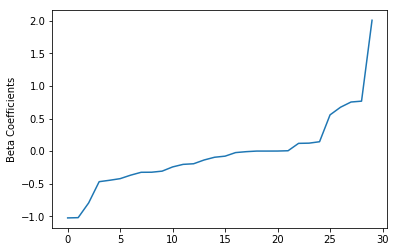

In [18]:
import matplotlib.pyplot as plt
import numpy as np

beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

In [19]:
predictions = lrModel.transform(test)

In [20]:
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 37|management|  0.0|[1.19871810716723...|       0.0|[0.76829666339830...|
| 40|management|  0.0|[2.20534940465796...|       0.0|[0.90072886169926...|
| 53|management|  0.0|[1.02590348276690...|       0.0|[0.73612093009497...|
| 32|management|  0.0|[1.25795481657702...|       0.0|[0.77867383994058...|
| 54|management|  0.0|[1.33232096924268...|       0.0|[0.79122429116078...|
| 40|management|  0.0|[1.57095096412779...|       0.0|[0.82791913346617...|
| 56|management|  0.0|[3.06095963426752...|       0.0|[0.95525333386804...|
| 50|management|  0.0|[-0.8102603273804...|       1.0|[0.30783502428597...|
| 47|management|  0.0|[0.67024288891379...|       0.0|[0.66155754396054...|
| 44|management|  0.0|[1.29756265761715...|       0.0|[0.78542449653716...|
+---+-------

In [21]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8858324614449619
